## Enhancing Mortality Prediction in Children with Pediatric Severe Febrile Illness: Integration of Biomarkers with Clinical Severity Scores 

### Introduction 

Severe febrile illness remains one of the leading causes of childhood mortality, particularly in low and middle income countries. While many cases are due to self-limited infections, there is a small yet critical percentage of children that develop life-threatening infections that require immediate medical attention. Despite the treatment advancements, identifying children at early risk of severe complications remains a challenge. Oftentimes, children with severe febrile disease experience nonspecific symptoms, making it hard to differentiate children who need urgent intervention from those with self-limiting infections. This delay and diagnostic uncertainty contribute to the increase in mortality rates in children who suffer with severe febrile illness (Balanza, 2020).  

To address this, the present study investigates whether adding specific biomarkers to existing clinical scores, quick Sequential Organ Failure Assessment (qSOFA) and Lambaréné Organ Dysfunction (LOD) scores, can improve prediction of in-hospital mortality in children with severe febrile illness. 


### Study Design and Population 

Study Design: This prospective cohort study was conducted at Muhimbili National Hospital (MNH), the primary national referral hospital and teaching hospital for Muhimbili University of Health and Allied Sciences (MUHAS) in Dar es Salaam, Tanzania. Children aged 28 days (about 4 weeks) to 14 years presenting with severe febrile illness between July 26, 2022, and November 26, 2024, were enrolled in the study. The primary outcome of interest was in-hospital mortality.  

Variables and Measures: Clinical data, vital signs, and lab results were collected including variables needed to calculate the qSOFA and LOD scores. Serum biomarkers were measured which included IL-10, Ang-2, IL-6, IL-1ra, IL-8, sTNFR-1, Protein C, RAGE, PAI-1, ICAM-1, and sTREM-1. Because biomarker distributions were right-skewed, continuous values were log-transformed for stable modeling. 

In addition to the biomarkers, a broad set of baseline characteristics were also collected to characterize the study population: age, sex, anthropometrics (weight, height, mid-upper arm circumference), and comorbidities (HIV status, malaria, malnutrition). Continuous variables with a skewed distribution were summarized using median and interquartile range (IQR), while normally distributed variables were summarized using mean and standard deviation (SD). 

Data Preprocessing: Data was cleaned and preprocessed in Python. Patients with missing outcome data or critical predictor values were excluded. Patients with outcomes recorded as "Left AMA" or "Transferred" were categorized as survivors. 

### Data Analysis 

Statistical Analysis: 

The area under the receiver operating characteristic curve (AUC) was used to assess each biomarker’s predictive power for in-hopsital mortality, and 95% confidence intervals were calculated for each. To determine whether the biomarker added predictive value beyond the clinical scores alone, logistic regression models were fitted that combined each biomarker with either the qSOFA or LOD scores. Models were restricted to complete cases. 

In addition to computing individual AUCs, random forest (RF) and extreme gradient boosting (XGBoost) classifiers were used to assess the relative importance of each biomarker. RF was implemented using randomForest package (n = 500 trees), and XGBoost was implemented with xgboost package using binary logistic objective. The biomarkers were ranked using Gini importance (RF) and gain (XGBoost).  

This dual approach was chosen to balance clinical interpretability with statistical robustness. Individual AUCs provide straightforward measures of each biomarker’s predictive ability alone and alongside clinical scores. However, this method does not account for correlations between biomarkers, potentially causing redundancy. On the other side, RF and XGBoost are multivariate methods that capture complex, nonlinear relationships and interactions, reducing overfitting risk, though their importance scores can be less interpretable clinically and do not directly measure incremental predictive gain. So by combining these two methods ensures biomarker utility is both clinically relevant and statistically sound.   

The biomarkers that consistently ranked highly across these both approaches, both strong individual predictive power and robust multivariate importance, were selected for combination with clinical severity scores. 

Predictive performance was evaluated using 100-times repeated 10-fold cross-validation, providing robust estimates of model generalizability and minimizing partition bias. Models including clinical scores and top biomarkers were compared based on mean AUC across folds. Discrimination was assessed in three ways: (1) biomarkers alone, (2) clinical scores plus all biomarkers, and (3) clinical scores and top biomarkers. ROC curves were generated for visualization, and improvements in AUC interpreted as evidence of additive predictive value. 

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("datasets/final_dataset.csv")
#those who are NA left AMA transferred will be considered as survived
df['outcome'] = df['outcome'].replace(['NA', 'Left AMA', 'Transferred'], 'Survived')
df_clean = df[df['outcome'].isin(['Died', 'Survived'])].copy()
df_clean['outcome'] = df_clean['outcome'].map({'Survived': 0, 'Died': 1})

✅ Outcome value counts:
outcome
0    323
1     69
Name: count, dtype: int64


In [ ]:
import pandas as pd

data = {
    "Variable": [
        "Age (months)", "Sex (Male)", "Moderate-Severe Malnutrition", "HIV Positive", 
        "Malaria Status by RDT", "Fully Vaccinated", "LOD 1 - Prostration/Weakness", 
        "LOD 2 - Breathing Difficulty", "LOD 3 - Altered Mental Status", "Hemoglobin (g/dL)", 
        "Glucose (mmol/L)", "White Blood Cell Count (per µL)", "Bloodstream Infection", 
        "Bacterial Pneumonia", "Pre-Hospital Antibiotics", "PICU Admission", "Length of Stay (hours)"
    ],
    "Total (n = 389)": [
        "18.0 (9.3, 42.4)", "225 (57.8%)", "141 (36.3%)", "7 (1.8%)", "18 (4.6%)", 
        "386 (99.2%)", "222 (57.1%)", "102 (26.2%)", "103 (26.5%)", "10.03 (8.5, 11.6)", 
        "5.4 (4.7, 6.4)", "10.32 (6.9, 15.1)", "31 (8.0%)", "74 (19.0%)", "179 (46.0%)", 
        "96 (24.7%)", "3.92 (1.7, 8.6)"
    ],
    "Survived (n = 320)": [
        "20.3 (10.7, 46.6)", "186 (58.1%)", "103 (32.2%)", "2 (0.6%)", "15 (4.7%)", 
        "318 (99.4%)", "176 (55.0%)", "56 (17.5%)", "53 (16.6%)", "10.2 (8.8, 11.6)", 
        "5.3 (4.7, 6.2)", "9.9 (6.5, 14.1)", "19 (5.9%)", "49 (15.3%)", "132 (41.3%)", 
        "44 (13.8%)", "4.2 (1.8, 8.6)"
    ],
    "Died (n = 69)": [
        "12.0 (6.8, 23.9)", "39 (56.5%)", "38 (55.1%)", "5 (7.3%)", "3 (4.4%)", 
        "68 (98.6%)", "46 (66.7%)", "46 (66.7%)", "50 (72.5%)", "9.2 (8.0, 11.1)", 
        "6.0 (4.4, 7.5)", "13.9 (9.6, 19.1)", "12 (17.4%)", "25 (36.2%)", "47 (68.1%)", 
        "52 (75.4%)", "3.0 (1.5, 8.4)"
    ],
    "p-value": [
        "0.324", "0.807", "<0.001", "0.002", "0.903", "0.444", "0.076", 
        "<0.001", "<0.001", "0.047", "0.058", "<0.001", "0.001", "<0.001", 
        "<0.001", "<0.001", "0.106"
    ]
}

table1 = pd.DataFrame(data)

print(table1)


                           Variable    Total (n = 389) Survived (n = 320)  \
0                      Age (months)   18.0 (9.3, 42.4)  20.3 (10.7, 46.6)   
1                        Sex (Male)        225 (57.8%)        186 (58.1%)   
2      Moderate-Severe Malnutrition        141 (36.3%)        103 (32.2%)   
3                      HIV Positive           7 (1.8%)           2 (0.6%)   
4             Malaria Status by RDT          18 (4.6%)          15 (4.7%)   
5                  Fully Vaccinated        386 (99.2%)        318 (99.4%)   
6      LOD 1 - Prostration/Weakness        222 (57.1%)        176 (55.0%)   
7      LOD 2 - Breathing Difficulty        102 (26.2%)         56 (17.5%)   
8     LOD 3 - Altered Mental Status        103 (26.5%)         53 (16.6%)   
9                 Hemoglobin (g/dL)  10.03 (8.5, 11.6)   10.2 (8.8, 11.6)   
10                 Glucose (mmol/L)     5.4 (4.7, 6.4)     5.3 (4.7, 6.2)   
11  White Blood Cell Count (per µL)  10.32 (6.9, 15.1)    9.9 (6.5, 14.1)   

Table 1 presents the baseline characteristics of children with severe febrile illness in Tanzania, stratified by survival status (survived vs. died). The total cohort includes 389 children, with 320 survivors and 69 non-survivors. The table summarizes both continuous and categorical variables, providing median (interquartile range, IQR) or mean (standard deviation, SD) for continuous variables, and number (percentage) for categorical variables. Key baseline characteristics examined include age, sex, malnutrition status, HIV status, malaria status, and vaccination status.

Notably, children who died were significantly more likely to have moderate-to-severe malnutrition, with 55.1% of non-survivors vs. 32.2% of survivors (p < 0.001). HIV positivity was more common among non-survivors, with 7.3% compared to just 0.6% in survivors (p = 0.002). The LOD score, which measures illness severity, was significantly higher in non-survivors (mean of 2.1) compared to survivors (mean of 0.9, p < 0.001), suggesting that more severe illness correlates with mortality. Furthermore, the white blood cell count was notably higher in non-survivors (13.9 × 10^3/µL) compared to survivors (9.9 × 10^3/µL, p < 0.001). In terms of clinical outcomes, 75.4% of non-survivors were admitted to the Pediatric Intensive Care Unit (PICU), significantly more than the 13.8% of survivors (p < 0.001).

These findings highlight the importance of clinical markers such as malnutrition status, LOD score, and blood cell counts in predicting mortality risk in this pediatric population. The data suggest that children with severe febrile illness who have high LOD scores, significant malnutrition, and elevated white blood cell counts are at increased risk of death, which could be used to inform early interventions and treatment strategies.

In [7]:
from sklearn.metrics import roc_auc_score

def bootstrap_auc_ci(y_true, y_scores, n_bootstraps=2000, alpha=0.05, random_seed=42):
    rng = np.random.RandomState(random_seed)
    bootstrapped_scores = []

    mask = ~np.isnan(y_scores)
    y_true = y_true[mask]
    y_scores = y_scores[mask]

    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_scores), len(y_scores))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_scores[indices])
        bootstrapped_scores.append(score)
    
    sorted_scores = np.array(bootstrapped_scores)
    lower = np.percentile(sorted_scores, 100 * (alpha / 2))
    upper = np.percentile(sorted_scores, 100 * (1 - alpha / 2))
    mean_score = np.mean(sorted_scores)
    
    return mean_score, lower, upper

# Variables
biomarkers = [
  "log_il10", "log_ang2", "log_il6", "log_il1ra", "log_il8",
  "log_tnfr1", "log_proc", "log_rage", "log_pai1", "log_icam1",
  "log_trem1"
]

# Outcome and predictors
y_true = df_clean['outcome'].values
biomarker_scores = {b: df_clean[b].values for b in biomarkers}
qSOFA_scores = df_clean['qSOFA'].values
LOD_scores = df_clean['lods_score'].values

results = []

for biomarker_name, biomarker_values in biomarker_scores.items():
    auc, lower, upper = bootstrap_auc_ci(y_true, biomarker_values)
    combined_qSOFA = biomarker_values + qSOFA_scores
    auc_q, lower_q, upper_q = bootstrap_auc_ci(y_true, combined_qSOFA)
    combined_LOD = biomarker_values + LOD_scores
    auc_l, lower_l, upper_l = bootstrap_auc_ci(y_true, combined_LOD)

    results.append({
        "Biomarker": biomarker_name,
        "Biomarker Score Alone (95% CI)": f"{auc:.3f} ({lower:.3f}–{upper:.3f})",
        "Biomarker + qSOFA (95% CI)": f"{auc_q:.3f} ({lower_q:.3f}–{upper_q:.3f})",
        "Biomarker + LOD (95% CI)": f"{auc_l:.3f} ({lower_l:.3f}–{upper_l:.3f})"
    })

# Add clinical scores alone
auc_qsofa, lower_qsofa, upper_qsofa = bootstrap_auc_ci(y_true, qSOFA_scores)
results.append({
    "Biomarker": "qSOFA",
    "Biomarker Score Alone (95% CI)": f"{auc_qsofa:.3f} ({lower_qsofa:.3f}–{upper_qsofa:.3f})",
    "Biomarker + qSOFA (95% CI)": "n/a",
    "Biomarker + LOD (95% CI)": "n/a"
})

auc_lod, lower_lod, upper_lod = bootstrap_auc_ci(y_true, LOD_scores)
results.append({
    "Biomarker": "LODS",
    "Biomarker Score Alone (95% CI)": f"{auc_lod:.3f} ({lower_lod:.3f}–{upper_lod:.3f})",
    "Biomarker + qSOFA (95% CI)": "n/a",
    "Biomarker + LOD (95% CI)": "n/a"
})

table2 = pd.DataFrame(results)
print(table2)


    Biomarker Biomarker Score Alone (95% CI) Biomarker + qSOFA (95% CI)  \
0    log_il10            0.711 (0.635–0.777)        0.755 (0.689–0.817)   
1    log_ang2            0.736 (0.658–0.803)        0.794 (0.729–0.851)   
2     log_il6            0.704 (0.635–0.771)        0.758 (0.696–0.814)   
3   log_il1ra            0.692 (0.615–0.760)        0.747 (0.681–0.805)   
4     log_il8            0.779 (0.709–0.841)        0.807 (0.745–0.860)   
5   log_tnfr1            0.766 (0.691–0.835)        0.818 (0.764–0.868)   
6    log_proc            0.319 (0.244–0.404)        0.570 (0.484–0.652)   
7    log_rage            0.750 (0.667–0.822)        0.797 (0.729–0.860)   
8    log_pai1            0.738 (0.665–0.803)        0.775 (0.707–0.836)   
9   log_icam1            0.572 (0.490–0.654)        0.705 (0.622–0.782)   
10  log_trem1            0.807 (0.750–0.860)        0.829 (0.773–0.878)   
11      qSOFA            0.715 (0.645–0.782)                        n/a   
12       LODS            

## Performance of Biomarkers in Predicting Mortality
The discriminative ability of each individual biomarker was evaluated for in-hospital mortality, both alone and when combined with the qSOFA and LOD scores. When used alone, STREM-1 showed the highest AUC (AUC 0.807, 95% CI: 0.750–0.860), followed by IL-8 (AUC 0.779, 95% CI: 0.709–0.841) and STNFR-1 (AUC 0.766, 95% CI: 0.691–0.835).

Addition of biomarkers to qSOFA improved model discrimination, with the highest AUCs observed for STREM-1 + qSOFA (AUC 0.829, 95% CI: 0.773–0.878), STNFR-1 + qSOFA (AUC 0.818, 95% CI: 0.764–0.868), and IL-8 + qSOFA (AUC 0.807, 95% CI: 0.745–0.860).

When combined with LOD score, there was a further improvement in discrimination. STREM-1 + LOD achieved the highest AUC (AUC 0.872, 95% CI: 0.834–0.907), followed by STNFR-1 + LOD (AUC 0.865, 95% CI: 0.818–0.905) and IL-8 + LOD (AUC 0.845, 95% CI: 0.789–0.889).

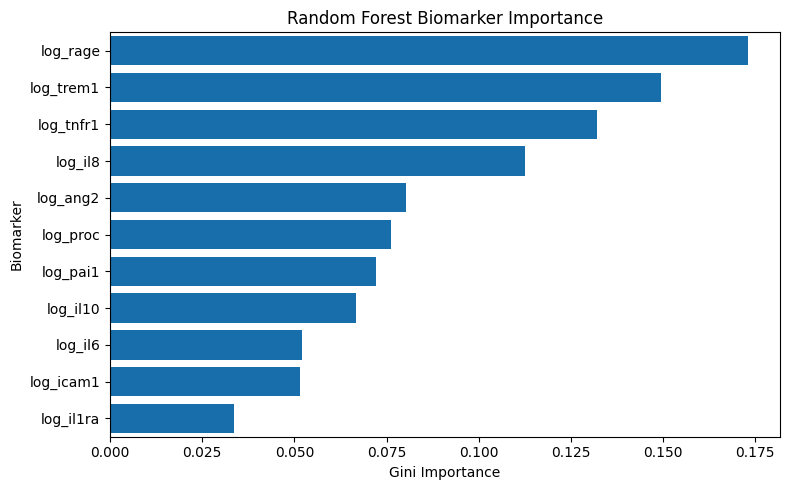

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:37:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:37:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:37:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:37:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/codespace/

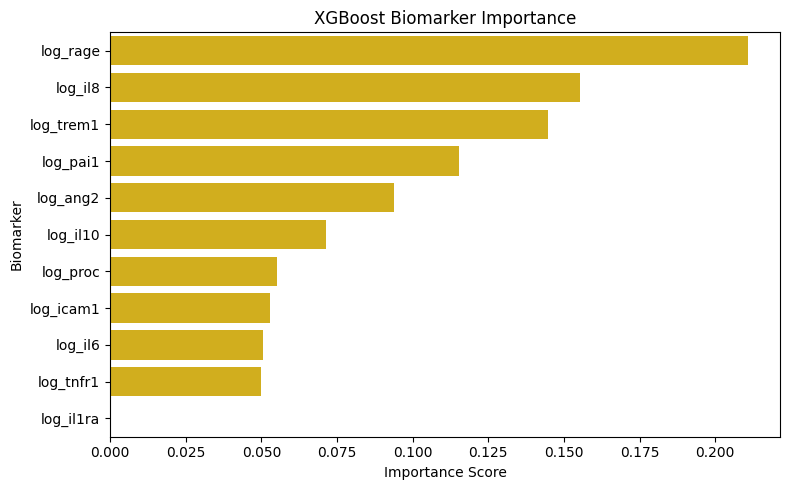

Top 5 Biomarkers (Random Forest):
    Biomarker  GiniImportance
7    log_rage        0.173058
10  log_trem1        0.149370
5   log_tnfr1        0.132207
4     log_il8        0.112445
1    log_ang2        0.080371

Top 5 Biomarkers (XGBoost):
    Biomarker  XGBImportance
7    log_rage       0.210879
4     log_il8       0.155361
10  log_trem1       0.144876
8    log_pai1       0.115360
1    log_ang2       0.093704


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


biomarkers = [
    "log_il10", "log_ang2", "log_il6", "log_il1ra", "log_il8",
    "log_tnfr1", "log_proc", "log_rage", "log_pai1", "log_icam1",
    "log_trem1"
]


df_clean = df.dropna(subset=biomarkers + ["outcome"])

# (0 = Survived, 1 = Died)
y = LabelEncoder().fit_transform(df_clean["outcome"])
X = df_clean[biomarkers]

# Random Forest
rf = RandomForestClassifier(
    n_estimators=1000,
    max_leaf_nodes=10,
    max_features='sqrt',
    random_state=123
)

rf.fit(X, y)

# Get importance
rf_importance = pd.DataFrame({
    "Biomarker": X.columns,
    "GiniImportance": rf.feature_importances_
}).sort_values("GiniImportance", ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x="GiniImportance", y="Biomarker", data=rf_importance, color="#0073C2FF")
plt.title("Random Forest Biomarker Importance")
plt.xlabel("Gini Importance")
plt.ylabel("Biomarker")
plt.tight_layout()
plt.show()

# XGBoost with cross-validation
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=123)

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [2, 3, 4]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    verbose=0
)

grid.fit(X, y)

# Best model
xgb_best = grid.best_estimator_

# Feature importance
xgb_importance = pd.DataFrame({
    "Biomarker": X.columns,
    "XGBImportance": xgb_best.feature_importances_
}).sort_values("XGBImportance", ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x="XGBImportance", y="Biomarker", data=xgb_importance, color="#EFC000FF")
plt.title("XGBoost Biomarker Importance")
plt.xlabel("Importance Score")
plt.ylabel("Biomarker")
plt.tight_layout()
plt.show()

print("Top 5 Biomarkers (Random Forest):")
print(rf_importance.head(5))

print("\nTop 5 Biomarkers (XGBoost):")
print(xgb_importance.head(5))



Biomarker importance was ranked by Gini importance in RF and by gain in XGBoost. In the RF model, the top five biomarkers were RAGE, STREM-1, STNFR-1, IL-8, and ANG2. In the XGBoost model, the top features were RAGE, IL-8, STREM-1, PAI-1, and ANG2. These machine learning models supported the AUC-based findings, reinforcing the selection of STREM-1, STNFR-1, and IL-8 as the top-performing biomarkers for further evaluation. 

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import numpy as np
import pandas as pd


models = {
    "LOD + sTREM-1": ["lods_score", "log_trem1"],
    "LOD + sTNFR-1": ["lods_score", "log_tnfr1"],
    "LOD + IL-8": ["lods_score", "log_il8"],
    "LOD + sTREM-1 + IL-8": ["lods_score", "log_trem1", "log_il8"],
    "LOD + sTREM-1 + sTNFR-1": ["lods_score", "log_trem1", "log_tnfr1"],
    "LOD + sTNFR-1 + IL-8": ["lods_score", "log_tnfr1", "log_il8"],
    "LOD + sTREM-1 + IL-8 + sTNFR-1": ["lods_score", "log_trem1", "log_il8", "log_tnfr1"],
    "qSOFA + sTREM-1": ["qSOFA", "log_trem1"],
    "qSOFA + sTNFR-1": ["qSOFA", "log_tnfr1"],
    "qSOFA + IL-8": ["qSOFA", "log_il8"],
    "qSOFA + sTREM-1 + IL-8": ["qSOFA", "log_trem1", "log_il8"],
    "qSOFA + sTREM-1 + sTNFR-1": ["qSOFA", "log_trem1", "log_tnfr1"],
    "qSOFA + sTNFR-1 + IL-8": ["qSOFA", "log_tnfr1", "log_il8"],
    "qSOFA + sTREM-1 + IL-8 + sTNFR-1": ["qSOFA", "log_trem1", "log_il8", "log_tnfr1"]
}

# CV setup
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=100, random_state=123)

results = []

# Run models
for model_name, features in tqdm(models.items(), desc="Running models"):
    try:
        data = df_clean[features + ['outcome']].dropna(subset=features)
        X = data[features]
        y = data['outcome']
        
        if len(y.unique()) < 2:
            raise ValueError("Not enough class variety")

        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression(solver='liblinear', class_weight='balanced'))
        ])

   
        aucs = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

     
        results.append({
            "Model": model_name,
            "AUC_ROC": round(np.mean(aucs), 3),
            "95% Lower CI": round(np.percentile(aucs, 2.5), 3),
            "95% Upper CI": round(np.percentile(aucs, 97.5), 3)
        })

    except Exception as e:
        results.append({
            "Model": model_name,
            "AUC_ROC": np.nan,
            "95% Lower CI": np.nan,
            "95% Upper CI": np.nan
        })
        print(f"Error with {model_name}: {e}")

table3 = pd.DataFrame(results).sort_values(by="AUC_ROC", ascending=False).reset_index(drop=True)
print(table3)


Running models: 100%|██████████| 14/14 [01:20<00:00,  5.75s/it]

                               Model  AUC_ROC  95% Lower CI  95% Upper CI
0               LOD + sTREM-1 + IL-8    0.882         0.754         0.973
1     LOD + sTREM-1 + IL-8 + sTNFR-1    0.879         0.750         0.973
2            LOD + sTREM-1 + sTNFR-1    0.876         0.750         0.969
3                      LOD + sTREM-1    0.873         0.751         0.969
4               LOD + sTNFR-1 + IL-8    0.870         0.719         0.978
5                      LOD + sTNFR-1    0.868         0.719         0.973
6                         LOD + IL-8    0.858         0.696         0.969
7             qSOFA + sTREM-1 + IL-8    0.849         0.696         0.964
8   qSOFA + sTREM-1 + IL-8 + sTNFR-1    0.842         0.692         0.964
9                    qSOFA + sTREM-1    0.826         0.656         0.963
10         qSOFA + sTREM-1 + sTNFR-1    0.826         0.670         0.955
11            qSOFA + sTNFR-1 + IL-8    0.821         0.625         0.955
12                   qSOFA + sTNFR-1  

Clinical-molecular models combining clinical scores with the top three biomarkers were assessed to validate their predictive performance. AUC-ROC and corresponding 95% confidence intervals were computed using 100-times repeated 10-fold cross-validation.

For LODS-based models, the highest AUC was observed for the combination of LOD + sTREM-1 + IL-8 (AUC = 0.882; 95% CI: 0.754–0.973), followed closely by LOD + sTREM-1 + sTNFR-1 (AUC = 0.876; 95% CI: 0.750–0.969).

For qSOFA-based models, the best performance was seen in the model combining qSOFA + sTREM-1 + IL-8 (AUC = 0.849; 95% CI: 0.696–0.964), followed by qSOFA + sTREM-1 + sTNFR-1 + IL-8 (AUC = 0.842; 95% CI: 0.692–0.964).

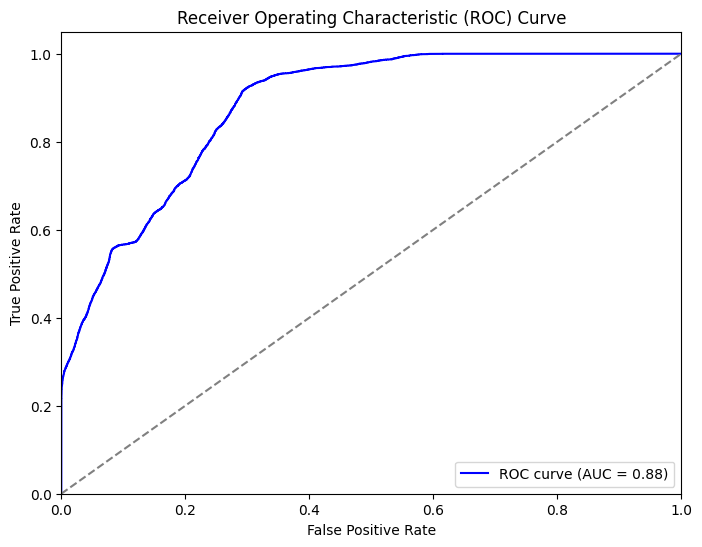

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt


best_model_data = df_clean  
best_model_features = ["lods_score", "log_trem1", "log_il8"]  #this the best model

imputer = SimpleImputer(strategy='mean')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=100, random_state=123)

pipeline = Pipeline([
    ('imputer', imputer),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear', class_weight='balanced'))
])


y_true_all = []
y_prob_all = []

# cv
for train_idx, val_idx in cv.split(best_model_data[best_model_features], best_model_data['outcome']):
    X_train, X_val = best_model_data[best_model_features].iloc[train_idx], best_model_data[best_model_features].iloc[val_idx]
    y_train, y_val = best_model_data['outcome'].iloc[train_idx], best_model_data['outcome'].iloc[val_idx]
    
    pipeline.fit(X_train, y_train)
    
    y_prob = pipeline.predict_proba(X_val)[:, 1]  # this the probabilities for the positive class
    
    y_true_all.extend(y_val)
    y_prob_all.extend(y_prob)


y_true_all = np.array(y_true_all)
y_prob_all = np.array(y_prob_all)

fpr, tpr, thresholds = roc_curve(y_true_all, y_prob_all)
roc_auc = auc(fpr, tpr)

#roc curve 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Discussion  

These findings show that the prediction of in-hospital mortality in children with severe febrile illness is improved by the addition of immune biomarkers to established clinical scores. The combination of TREM-1 and IL-8 with the LOD score yielded the highest predictive performance for in-hospital mortality, with a cross-validated AUC of 0.882 (95% CI: 0.754–0.973). This implies that clinical scoring systems combined with targeted biomarkers can significantly improve predictive accuracy.  

Important differences distinguish this analysis from earlier research that assessed the role of biomarkers in sepsis mortality. Most existing research has focused on adults, and those that studied pediatric populations have often been limited to children under five years old with acute febrile illness. The current analysis, on the other hand, included a broader pediatric population up to 14 years of age which better represents clinical settings in low- and middle-income countries. Population differences are important when interpreting biomarker performance because immunological responses can differ greatly with age which can result in differences in results.  

Additionally, because qSOFA is typically understudied in pediatric populations and other clinical score systems are more widely used, many previous studies have not thoroughly examined it. While previous studies applied machine learning to integrate biomarkers with clinical scores such as the Universal Vital Assessment (Cummings et al., 2023), or evaluated standalone biomarkers (Chandna et al., 2025), few have systematically assessed the incremental predictive value of adding biomarkers to clinical scores like qSOFA and LOD. To increase the robustness of the results, the current study used a rigorous modeling strategy with 100-times repeated 10-fold cross-validation.  

These findings suggest several potential avenues for future research. External validation in separate pediatric populations are needed to confirm generalizability. Future studies should examine how to integrate these high performing biomarkers into clinical workflows. Additionally, stratifying children into risk categories (e.g., low, medium, and high) based on the combined models to help guide doctors in making treatment plans. This could help identify children who require intensive care right away versus those who can be monitored more closely. 

## Work Citation 

Balanza, N., Erice, C., Ngai, M., Varo, R., Kain, K. C., & Bassat, Q. (2020). Host-Based 	 
Prognostic Biomarkers to Improve Risk Stratification and Outcome of Febrile Children in Low- and Middle-Income Countries. Frontiers in pediatrics, 8, 552083. https://doi.org/10.3389/fped.2020.552083 

Chandna, A., Koshiaris, C., Mahajan, R., Ahmad, R. A., Anh, D. T. V., Keang, S., ... & Burza, S. 	(2025). Risk stratification of childhood infection using host markers of immune and 	endothelial activation: a multi-country prospective cohort study in Asia (Spot Sepsis). 	medRxiv, 2025-02. 

Cummings, M. J., Bakamutumaho, B., Jain, K., Price, A., Owor, N., Kayiwa, J., ... & O’Donnell, 	M. R. 	(2023). Development of a Novel Clinicomolecular Risk Index to Enhance 		Mortality Prediction and Immunological Stratification of Adults Hospitalized with Sepsis in 	Sub-Saharan Africa: A Pilot Study from Uganda. The American Journal of Tropical 	Medicine and Hygiene, 108(3), 619. 